# Adoption Classification


**PetFinder Prediction**

The Petfinder dataset is about predicting how fast a pet is adopted based on pet's listing on PetFinder. The goal is to classify if the pet will be adopted or not.

**Processing Steps**
- Load training and test data including labels
- Handle the categorical values using a pipeline
- Create a Neural Network and build a model
- Train the model on the training dataset
- Evaluate the accuracy of the model using test dataset
- Plot the accuracy and loss for the model

## Data Fields
- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


## AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:<br>
0 - Pet was adopted on the same day as it was listed.<br>
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.<br>
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.<br>
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.<br>
4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).<br> 

In [1]:
# importing packages/libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
import pydot
import warnings

from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline
# plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Importing the datasets (train and test)

In [2]:
# reading train df
traindf = pd.read_csv('./data/pet-train.csv', encoding = 'utf-8')

In [3]:
# checking shape
traindf.shape

(14993, 24)

In [4]:
# checking first rows
traindf.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


In [5]:
# processing the 'type' column
traindf['Type'] = traindf['Type'].map({1: 'Dog', 2: 'Cat'})

In [6]:
# checking first rows
traindf.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,Cat,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,Cat,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,Dog,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


### Using the test dataset to evaluate the model

In [7]:
# reading the test data
evaldf = pd.read_csv('./data/pet-test.csv', encoding = 'utf-8')

In [8]:
# checking shape
evaldf.shape

(3948, 23)

In [9]:
# checking firt rows
evaldf.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1,Puppy,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,2,London,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0


In [10]:
# processing the 'type' col
evaldf['Type'] = evaldf['Type'].map({1: 'Dog', 2: 'Cat'})

In [11]:
# checking first few rows
evaldf.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,Dog,Puppy,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,Cat,London,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0


## Creating Target Variable

Transform this into a binary classification problem, and simply predict whether the pet was adopted, or not. After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

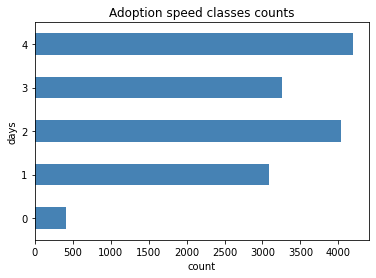

In [12]:
# plotting 'AdoptionSpeed'
traindf['AdoptionSpeed'].value_counts().sort_index().plot(kind = 'barh', color='steelblue')
plt.xlabel('count')
plt.ylabel('days')
plt.title('Adoption speed classes counts')
plt.rc('grid', linestyle="-", color='black')
plt.show()

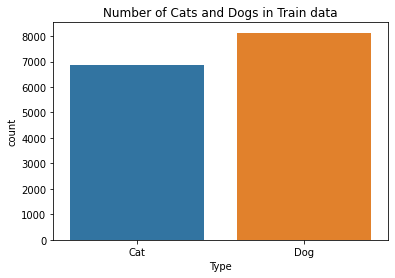

In [13]:
# plotting 'type'
plt.figure(figsize=(6, 4));
sns.countplot(x='Type', data = traindf);
plt.title('Number of Cats and Dogs in Train data');

In [14]:
# defining cols to drop
todrop = ['Name', 'RescuerID', 'PetID', 'AdoptionSpeed', 'Description' ]

In [15]:
# defining tartget col - in the original dataset "4" indicates the pet was not adopted.
traindf['target'] = np.where(traindf['AdoptionSpeed'] == 4, 0, 1)

In [16]:
# dropping cols
traindf.drop(columns = todrop, axis = 1, inplace = True)

In [17]:
# transposing df
traindf.head().transpose()

,0,1,2,3,4
Type,Cat,Cat,Dog,Dog,Dog
Age,3,1,1,4,1
Breed1,299,265,307,307,307
Breed2,0,0,0,0,0
Gender,1,1,1,2,1
Color1,1,1,2,1,1
Color2,7,2,7,2,0
Color3,0,0,0,0,0
MaturitySize,1,2,2,2,2
FurLength,1,2,2,1,1


In [18]:
# droppping 'AdoptionSpeed' features does not exist in the test data 
todrop.remove('AdoptionSpeed')

In [19]:
# defining target column
targetCol = traindf.pop('target')

In [20]:
# checking cols to drop
todrop

['Name', 'RescuerID', 'PetID', 'Description']

In [21]:
# dropping cols
evaldf.drop(columns = todrop, axis = 1, inplace = True)

In [22]:
# transposing eval df
evaldf.head().transpose()

,0,1,2,3,4
Type,Dog,Cat,Cat,Cat,Dog
Age,2,24,20,5,6
Breed1,307,266,266,266,307
Breed2,0,0,0,252,0
Gender,1,1,2,2,2
Color1,1,2,7,1,1
Color2,0,7,0,6,2
Color3,0,0,0,7,7
MaturitySize,2,2,2,2,2
FurLength,2,1,1,1,1


## Handling Cateogorical Data

In [23]:
# defining list of cols
cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'Health']

In [24]:
# converting numbers to strings for these categorical columns
for col in cat_cols:
    traindf[col] = traindf[col].astype(str)
    evaldf[col] = evaldf[col].astype(str)

In [25]:
# checking data types
traindf.dtypes

Type             object
Age               int64
Breed1           object
Breed2           object
Gender           object
Color1           object
Color2           object
Color3           object
MaturitySize     object
FurLength        object
Vaccinated       object
Dewormed         object
Sterilized       object
Health           object
Quantity          int64
Fee               int64
State            object
VideoAmt          int64
PhotoAmt        float64
dtype: object

In [26]:
# checking first rows
traindf.head(2)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
0,Cat,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0
1,Cat,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0


## Building Model Pipeline

In [27]:
# defining the pipeline stages for numeric and categorical columns
numericPipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])
stringPipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', 
                                                       fill_value='missing')),
                             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [28]:
# creating list of numeric and categorical columns
numericCols = traindf.select_dtypes(include=['int64', 'float64']).columns
stringCols = traindf.select_dtypes(include=['object']).columns

In [29]:
# checking numericCols
numericCols

Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt'], dtype='object')

In [30]:
# checking stringCols
stringCols

Index(['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'Health', 'State'],
      dtype='object')

In [31]:
# defining preprocessor
preprocessor = ColumnTransformer(transformers=[('num', numericPipe, numericCols),
                                               ('cat', stringPipe, stringCols)])

In [32]:
# defining df with traindf
df1 = preprocessor.fit_transform(traindf)

In [33]:
# checking shape
traindf.shape

(14993, 19)

In [34]:
# checking shape
df1.shape

(14993, 374)

In [35]:
# defining matrix list of values - look at first row in the sparse matrix
tlist = []
count = 0
for i in df1:
    tlist.append(list(i.A[0]))
    count += 1
    if (count >= 1):
        break
print(tlist)

[[-0.41046553193972646, -0.3912373126747355, 1.0041840496187642, -0.1639637418469582, -0.8284026711930884, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

In [36]:
# deininf evaldf1
evaldf1 = preprocessor.transform(evaldf)

In [37]:
# checking shape
evaldf1.shape

(3948, 374)

In [38]:
# defining y as the list of targetCol values
y = targetCol.values

## Creating Training and Test Datasets

In [39]:
# defining train and test sets
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.25, 
                                                    random_state = 2345)

In [40]:
# checking shape
X_train.shape

(11244, 374)

In [41]:
# checking shape
X_test.shape

(3749, 374)

## Building Neural Network

In [42]:
# instantiating the model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [43]:
# compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [44]:
# getting model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               96000     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 133,057
Trainable params: 133,057
Non-trainable params: 0
_________________________________________________________________


In [45]:
# rankdir='LR' is used to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [46]:
# converting the sparse matrix to numpy array so that validation split can 
# be applied when training the model
X_train = X_train.toarray()
X_test = X_test.toarray()

In [47]:
# training the model
EPOCHS = 50
BATCHES = 128
history = model.fit(X_train, y_train, batch_size = BATCHES, validation_split = 0.20,
                    epochs = EPOCHS, verbose = 2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/50
8995/8995 - 1s - loss: 0.5818 - accuracy: 0.7097 - val_loss: 0.5639 - val_accuracy: 0.7221
Epoch 2/50
8995/8995 - 0s - loss: 0.5625 - accuracy: 0.7274 - val_loss: 0.5648 - val_accuracy: 0.6892
Epoch 3/50
8995/8995 - 0s - loss: 0.5559 - accuracy: 0.7405 - val_loss: 0.5604 - val_accuracy: 0.7243
Epoch 4/50
8995/8995 - 0s - loss: 0.5499 - accuracy: 0.7465 - val_loss: 0.5594 - val_accuracy: 0.7394
Epoch 5/50
8995/8995 - 0s - loss: 0.5441 - accuracy: 0.7588 - val_loss: 0.5585 - val_accuracy: 0.7225
Epoch 6/50
8995/8995 - 0s - loss: 0.5393 - accuracy: 0.7681 - val_loss: 0.5589 - val_accuracy: 0.7172
Epoch 7/50
8995/8995 - 0s - loss: 0.5337 - accuracy: 0.7775 - val_loss: 0.5597 - val_accuracy: 0.7292
Epoch 8/50
8995/8995 - 0s - loss: 0.5303 - accuracy: 0.7871 - val_loss: 0.5575 - val_accuracy: 0.7359
Epoch 9/50
8995/8995 - 0s - loss: 0.5270 - accuracy: 0.7910 - val_loss: 0.5607 - val_accuracy: 0.7323
Epoch 10/50
8995/8995 - 0s - loss:

In [48]:
# getting metrics
metrics_names = model.metrics_names
metrics_names

['loss', 'accuracy']

In [49]:
# defining fucntion to plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and Validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

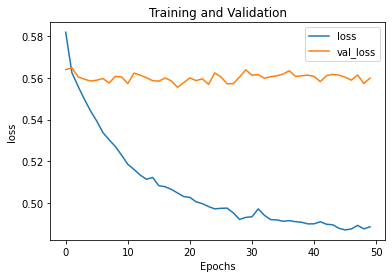

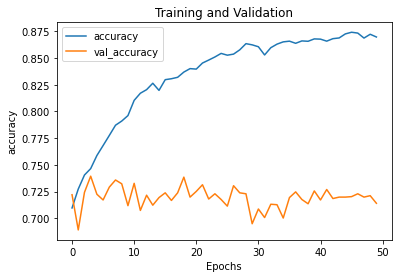

In [50]:
# plotting
for name in metrics_names:
    plot_graphs(history, name)

In [51]:
# getting accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy", accuracy)

3749/3749 [==============================] - 0s 30us/sample - loss: 0.5505 - accuracy: 0.7234
Accuracy 0.7233929


## Evaluating with the Evaluation Dataset

In [52]:
# getting predictions
evaldf1 = evaldf1.toarray()
preds = model.predict(evaldf1)

In [53]:
# checking predictions
preds = preds.astype(int)
preds[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [54]:
# passing preds to the target col
evaldf['target'] = preds

In [55]:
# checking first rows
evaldf.head(2)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,target
0,Dog,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,0,3.0,0
1,Cat,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,0,1.0,0


In [56]:
# counting target col == 1
evaldf.loc[evaldf['target'] == 1, 'target'].count()

1512

In [57]:
# counting target col == 0
evaldf.loc[evaldf['target'] == 0, 'target'].count()

2436